In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

### Data Import

In [56]:
#Loading the datasets 
anime_data = pd.read_csv('./archive/anime_with_synopsis.csv')
user_data = pd.read_csv('./archive/rating_complete.csv', low_memory=False)
print(anime_data.shape)
anime_data.head()
print(user_data.shape)
user_data.head()

(16214, 5)
(57633278, 3)


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [57]:
# for anime, remove "Unkown" in score column
anime_data = anime_data[(anime_data["Score"] != "Unknown")]
print(anime_data.shape)
# remove duplicates
anime_data = anime_data.drop_duplicates(subset='Name')
print(anime_data.shape)
# remove anime withou sypnopsis
anime_data = anime_data[anime_data['sypnopsis'] != "No synopsis information has been added to this title. Help improve our database by adding a synopsis here ."]
print(anime_data.shape)

(11091, 5)
(11090, 5)
(10914, 5)


In [58]:
# rearrange anime_data via unique anime_id
anime_ids = anime_data['MAL_ID'].unique().tolist()
anime2_encoded = {x: i for i, x in enumerate(anime_ids)}
encoded2_anime = {i: x for i, x in enumerate(anime_ids)}
anime_data["anime"] = anime_data["MAL_ID"].map(anime2_encoded)

anime_data.head(10)

,MAL_ID,Name,Score,Genres,sypnopsis,anime
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",2
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,3
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,4
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...,5
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college...",6
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...,7
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...,8
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",9


In [59]:
# rearrange user_data via unique user_id
user_ids = user_data["user_id"].unique().tolist()
user2_encoded = {x: i for i, x in enumerate(user_ids)}
encoded2_user = {i: x for i, x in enumerate(user_ids)}
user_data["user"] = user_data["user_id"].map(user2_encoded)

user_data.head()

,user_id,anime_id,rating,user
0,0,430,9,0
1,0,1004,5,0
2,0,3010,7,0
3,0,570,7,0
4,0,2762,9,0


In [60]:
# rearrange user_data via unique anime_id
# anime_data_to_merge = anime_data[['MAL_ID','anime']]
user_data = user_data.merge(anime_data,left_on="anime_id",right_on="MAL_ID",how='inner')
user_data=user_data[['user_id','anime_id','rating','user','anime','Name','Score']]
# user_data=user_data[(user_data["anime"] != "nan")]
user_data.head()

,user_id,anime_id,rating,user,anime,Name,Score
0,0,430,9,0,392,Fullmetal Alchemist: The Conqueror of Shamballa,7.57
1,6,430,8,6,392,Fullmetal Alchemist: The Conqueror of Shamballa,7.57
2,18,430,10,17,392,Fullmetal Alchemist: The Conqueror of Shamballa,7.57
3,19,430,8,18,392,Fullmetal Alchemist: The Conqueror of Shamballa,7.57
4,33,430,4,31,392,Fullmetal Alchemist: The Conqueror of Shamballa,7.57


In [61]:
a = user_data['user'].unique().tolist()
b = user_data['anime'].unique().tolist()
print(len(a),len(b),len(user_data))

309478 10817 56546235


### Content-based Recommendation
- Note: all anime-indexs below are rearranged index, i.e. anime_data['anime'].

In [62]:
def get_anime_ids(user_id):
    return user_data[user_data['user']==user_id]['anime'].values.tolist()

def get_user_ratings(user_id,anime_index):
    rating = user_data[user_data['anime']==anime_index]
    rating = rating[user_data['user']==user_id]['rating']
    return float(rating)

def get_anime_ratings(anime_index):
    rating = anime_data['Score'].iloc[anime_index]
    return float(rating)

# return corresponding recommendation lists (overall rating>6) based on anime which the user watched and rated >= 7
def recommend(user_id, similarity_matrix, number_of_recommendations = 10):
    anime_ids_list = get_anime_ids(user_id)
    index_list = []
    for anime in anime_ids_list:
        rating = get_user_ratings(user_id, int(anime))
        if rating >= 7:
            index_list.append(int(anime))
    recommend_dict = {}
    for index in index_list:
        recommend_list = []
        similarity_scores = sorted(list(enumerate(similarity_matrix[index])),key=lambda x: x[1], reverse=True)
        recommendations_indices = [t[0] for t in similarity_scores[1:(number_of_recommendations+1)]]
        for anime_index in recommendations_indices:
            rating = get_anime_ratings(anime_index)
            if rating > 6:
                recommend_list.append(anime_index)
            recommend_dict[index] = recommend_list
    return recommend_dict

# return top 10 recommedations after finding all possible recommendation lists
def get_top_20_recommedation(recommend_dict):
    full_list = []
    for item in recommend_dict:
        for index in recommend_dict[item]:
            rating = get_anime_ratings(index)
            if [index,rating] not in full_list:
                full_list.append([index,rating])
    full_list = sorted(full_list,key=lambda x: x[1])
    top_20_list = [elem[0] for elem in full_list[len(full_list)-20:]]
    # print(top_20_list)
    return anime_data['Name'].iloc[top_20_list]

def get_output(topNlist):
    res = pd.DataFrame(columns=['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis', 'anime'])
    for name in topNlist:
        df = anime_data[anime_data['Name'] == name]
        res = res.append(df, ignore_index = True)
    res = res[['MAL_ID', 'Name', 'Score']]
    return res

1. Content-based recommendation only based on the anime's sypnopsis

[[1.         0.22970997 0.01532238 ... 0.03230429 0.         0.        ]
 [0.22970997 1.         0.03621228 ... 0.         0.         0.        ]
 [0.01532238 0.03621228 1.         ... 0.         0.         0.        ]
 ...
 [0.03230429 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.24083262]
 [0.         0.         0.         ... 0.         0.24083262 1.        ]]


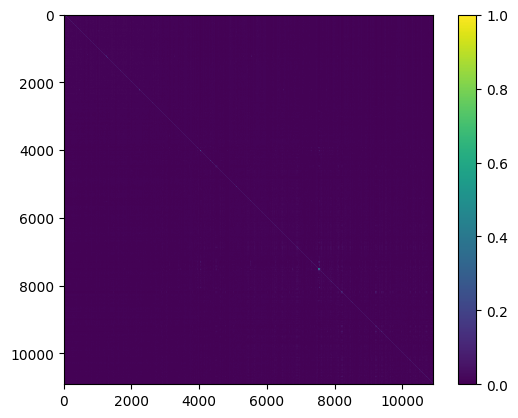

In [63]:
# represent sypnopsis via TF-IDF values to calculate their similarity
tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_matrix = tf_idf.fit_transform(anime_data['sypnopsis'].astype('U').values)

# calculating cosine similarity
cosine_similarity_matrix = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
print(cosine_similarity_matrix)
plt.imshow(cosine_similarity_matrix)
plt.colorbar()

In [64]:
recommendation_list_1 = recommend(0,cosine_similarity_matrix)
print(recommendation_list_1)
# print(get_top_20_recommedation(recommendation_list_1))
top_20_recommedation1 = get_top_20_recommedation(recommendation_list_1)
top20_output1 = get_output(top_20_recommedation1)
top20_output1

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']


{392: [100, 3357, 4618, 9576, 6437, 7383, 2308, 5140, 1760, 2782], 2471: [3074, 4969, 2241, 3698, 5529, 1943, 8039, 2960], 524: [257, 28, 779, 638, 710, 874, 1084, 971, 3367], 2317: [2047, 6624, 5214, 3288, 1067, 489, 6749], 393: [9705, 9211, 10532, 3122, 1912, 3684, 135, 1664, 2444], 531: [6039, 1578, 234, 481, 1170, 3624, 7795], 1368: [1561, 8687, 615, 285, 1440, 10621, 267, 4984], 100: [3357, 392, 4618, 5140, 3797, 4441, 9576, 10649, 6437], 322: [6945, 6585, 8640, 7183, 8314, 4891, 8814, 5285, 9511, 7065], 1114: [8481, 7889, 7631, 7198, 4553, 5714, 10575, 420, 11], 1583: [6878, 2313, 568, 2348, 10471, 2784, 1566, 3053], 2676: [3501, 1312, 5879, 2594, 2152, 2161, 806], 142: [8805, 584, 7622, 2019, 7174, 217], 1641: [10770, 3474, 3732, 440, 8559, 706, 10895, 3409, 1127], 377: [3858, 4252, 2467, 7599, 2280, 9331, 3270, 5029], 1939: [3402, 95, 6148, 6396, 10405], 1766: [8981, 588, 3176, 3359, 5614, 6508, 489], 2144: [3875, 844, 8328, 4565, 4521, 4623, 7647, 2152], 147: [9707, 3391, 6632

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(df, ignore_index = True)


,MAL_ID,Name,Score
0,121,Fullmetal Alchemist,8.17
1,47,Akira,8.17
2,4155,One Piece Film: Strong World,8.17
3,38234,One Piece Movie 14: Stampede,8.18
4,12859,One Piece Film: Z,8.18
5,34636,Ballroom e Youkoso,8.21
6,19123,One Piece: Episode of Merry - Mou Hitori no Na...,8.21
7,22297,Fate/stay night: Unlimited Blade Works,8.22
8,25537,Fate/stay night Movie: Heaven's Feel - I. Pres...,8.26
9,28701,Fate/stay night: Unlimited Blade Works 2nd Season,8.33


2. Content-based recommendation based on hybrid feature (genre + sypnopsis)

In [65]:
# construct the hybrid feature
# the weight of genre is larger than that of sypnosis
w_genre = 3
w_sypnopsis = 1

def hybrid_feature(df_row):
    genres = df_row['Genres']
    sypnopsis=df_row['sypnopsis']
    
    return " ".join(map(str,([genres]*w_genre)))+' '+" ".join(map(str,([sypnopsis]*w_sypnopsis)))

anime_data['hybrid_feature'] = anime_data.apply(hybrid_feature,axis=1)

anime_data.head()

,MAL_ID,Name,Score,Genres,sypnopsis,anime,hybrid_feature
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",0,"Action, Adventure, Comedy, Drama, Sci-Fi, Spac..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1,"Action, Drama, Mystery, Sci-Fi, Space Action, ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",2,"Action, Sci-Fi, Adventure, Comedy, Drama, Shou..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,3,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,4,"Adventure, Fantasy, Shounen, Supernatural Adve..."


[[1.         0.44504083 0.34467939 ... 0.05184758 0.         0.18898224]
 [0.44504083 1.         0.28428677 ... 0.         0.10302042 0.        ]
 [0.34467939 0.28428677 1.         ... 0.         0.0937195  0.1488875 ]
 ...
 [0.05184758 0.         0.         ... 1.         0.         0.        ]
 [0.         0.10302042 0.0937195  ... 0.         1.         0.05994906]
 [0.18898224 0.         0.1488875  ... 0.         0.05994906 1.        ]]


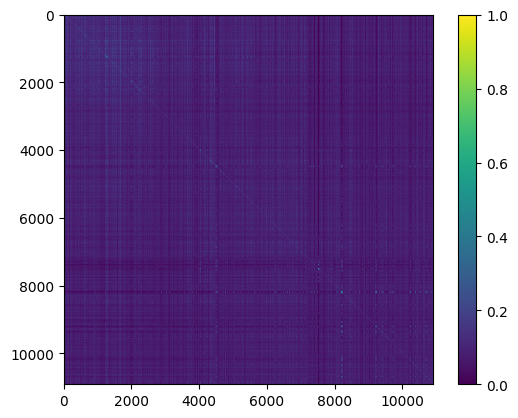

In [66]:
# convert hybrid features into comparable values
vect = CountVectorizer(stop_words='english')
vect_matrix = vect.fit_transform(anime_data['hybrid_feature'])

# calculating cosine similarity
cosine_similarity_matrix_count_based = cosine_similarity(vect_matrix, vect_matrix)
print(cosine_similarity_matrix_count_based)
plt.imshow(cosine_similarity_matrix_count_based)
plt.colorbar()

In [67]:
recommendation_list_2 = recommend(0,cosine_similarity_matrix_count_based)
print(recommendation_list_2)
top_20_recommedation2 = get_top_20_recommedation(recommendation_list_2)
top20_output2 = get_output(top_20_recommedation2)
top20_output2

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']


{392: [607, 100, 3357, 8773, 4728, 4618, 8338, 1901, 8863], 2471: [4364, 8388, 882, 4631, 10169, 5451, 2887], 524: [1913, 694, 4448, 9553, 3446, 1708, 8377], 2317: [8467, 8644, 473, 646, 2491, 7140, 8962, 742, 2964], 393: [10234, 9276, 1901, 843, 5625, 4605, 6073, 8246, 5994], 531: [3624, 4415, 4849, 5478, 1578, 6039, 3241, 4868], 1368: [5655, 4638, 4656, 9581, 4279, 7594, 5996, 4984], 100: [3357, 4618, 607, 392, 3797, 6445, 8602, 3179, 5770, 10749], 322: [6945, 8315, 6585, 5422, 7183, 4175, 8640, 3984, 8314, 10601], 1114: [712, 4325, 8498, 5915, 8004, 9479, 5770, 9807, 421, 420], 1583: [2352, 4152, 10240, 10850, 6036, 8637, 9930, 7860, 8920], 2676: [10491, 5127, 4938, 3636, 3672, 7717, 10816, 2260], 142: [9555, 9554, 9920, 10090, 10776, 7023, 1603, 9384], 1641: [3443, 2082, 9591, 3244, 10356, 1978], 377: [6357, 2467, 7599, 3858, 3743, 5217], 1939: [2206, 10563, 2534, 2135, 2421, 10391, 7189, 4903], 1766: [8659, 8621, 7256, 4436, 9082, 4984, 3727, 7128, 5450, 5963], 2144: [2350, 4723, 

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(df, ignore_index = True)


,MAL_ID,Name,Score
0,6904,Hellsing: Digest for Freaks,7.67
1,517,School Rumble: Ichi Gakki Hoshuu,7.75
2,1824,Hadashi no Gen,7.79
3,12017,Tiger & Bunny Movie 2: The Rising,7.81
4,9088,Saiyuuki Gaiden,7.84
5,34100,Fate/kaleid liner Prisma☆Illya Movie: Sekka no...,7.98
6,8740,One Piece Film: Strong World Episode 0,8.0
7,846,School Rumble Ni Gakki,8.03
8,6421,Fullmetal Alchemist: Brotherhood Specials,8.03
9,15323,One Piece: Episode of Nami - Koukaishi no Nami...,8.15


### Model Evaluation
Use hit rate to evaluate the content-based recommendation system. Find the rate of hitted anime (existing anime in the user's anime list) in the top 20 recommendation.

In [68]:
def name_to_anime_id(name):
    return anime_data[anime_data['Name']==name]['anime']
    
def HitRate(topNPredicted, leftOutList):
    hits = 0
    # total = 0

 # For each left-out rating
    for leftOut in leftOutList:
        hit = False
        for anime_name in topNPredicted:
            anime_id = name_to_anime_id(anime_name)
            if (int(leftOut) == int(anime_id)):
                hit = True
                break
        if (hit) :
            hits += 1

    # Compute overall precision
    return hits/20

In [69]:
user_id_list = list(range(0,len(user_ids),10000))
print(user_id_list)
print(len(user_id_list))

[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000]
32


In [70]:
# only based on sypnopsis
rate1 = []
for user_id in user_id_list:
    user_existing_anime_list = get_anime_ids(user_id)
    recommendation_list_1 = recommend(user_id,cosine_similarity_matrix)
    top_20_recommedation = get_top_20_recommedation(recommendation_list_1)
    hit_rate = HitRate(top_20_recommedation,user_existing_anime_list)
    rate1.append(hit_rate)
print(rate1)

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']


[0.05, 0.15, 0.35, 0.3, 0.45, 0.45, 0.3, 0.35, 0.45, 0.5, 0.45, 0.25, 0.75, 0.4, 0.0, 0.0, 0.55, 0.5, 0.55, 0.05, 0.1, 0.3, 0.4, 0.25, 0.3, 0.2, 0.1, 0.4, 0.3, 0.0, 0.5, 0.4]


In [71]:
# based on sypopsis and genres
rate2 = []
for user_id in user_id_list:
    user_existing_anime_list = get_anime_ids(user_id)
    recommendation_list_2 = recommend(user_id,cosine_similarity_matrix_count_based)
    top_20_recommedation = get_top_20_recommedation(recommendation_list_2)
    hit_rate = HitRate(top_20_recommedation,user_existing_anime_list)
    rate2.append(hit_rate)
print(rate2)

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']


[0.05, 0.1, 0.4, 0.3, 0.6, 0.4, 0.35, 0.25, 0.5, 0.4, 0.2, 0.2, 0.6, 0.3, 0.0, 0.0, 0.5, 0.5, 0.45, 0.1, 0.1, 0.3, 0.35, 0.45, 0.25, 0.15, 0.05, 0.35, 0.2, 0.0, 0.55, 0.25]


In [72]:
def compare_lists(l1,l2):
    count = 0
    for i in range(len(l1)):
        if l1[i] >= l2[i]:
            count += 1
    return count

compare_lists(rate1,rate2)

25

### Sample output

In [85]:
user_existing_anime_list = get_anime_ids(100)
recommendation_list_1 = recommend(100,cosine_similarity_matrix)
top_20_recommedation = get_top_20_recommedation(recommendation_list_1)
sample_1 = get_output(top_20_recommedation)
hit_rate = HitRate(top_20_recommedation,user_existing_anime_list)
print("The hit rate for user_id = 100 only using sypnopsis:", hit_rate)

user_existing_anime_list = get_anime_ids(100)
recommendation_list_2 = recommend(100,cosine_similarity_matrix_count_based)
top_20_recommedation = get_top_20_recommedation(recommendation_list_2)
sample_2 = get_output(top_20_recommedation)
hit_rate = HitRate(top_20_recommedation,user_existing_anime_list)
print("The hit rate for user_id = 100 using the hybrid feature:", hit_rate)

C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']
C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(df, ignore_index = True)


The hit rate for user_id = 100 only using sypnopsis: 0.45


C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating = rating[user_data['user']==user_id]['rating']
C:\Users\Windy\AppData\Local\Temp\ipykernel_18772\2366687778.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(df, ignore_index = True)


The hit rate for user_id = 100 using the hybrid feature: 0.4


In [83]:
sample_1 = sample_1.sort_values('Score',ascending=False)
sample_1.reset_index(drop = True, inplace = True)
sample_1

,MAL_ID,Name,Score
0,40028,Shingeki no Kyojin: The Final Season,9.17
1,11061,Hunter x Hunter (2011),9.1
2,38524,Shingeki no Kyojin Season 3 Part 2,9.1
3,820,Ginga Eiyuu Densetsu,9.07
4,4181,Clannad: After Story,8.96
5,32935,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,8.87
6,37491,Gintama.: Shirogane no Tamashii-hen - Kouhan-sen,8.86
7,37510,Mob Psycho 100 II,8.84
8,1,Cowboy Bebop,8.78
9,36862,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,8.74


In [84]:
sample_2 = sample_2.sort_values('Score',ascending=False)
sample_2.reset_index(drop = True, inplace = True)
sample_2

,MAL_ID,Name,Score
0,40028,Shingeki no Kyojin: The Final Season,9.17
1,11061,Hunter x Hunter (2011),9.1
2,38524,Shingeki no Kyojin Season 3 Part 2,9.1
3,820,Ginga Eiyuu Densetsu,9.07
4,32935,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,8.87
5,37510,Mob Psycho 100 II,8.84
6,199,Sen to Chihiro no Kamikakushi,8.83
7,33050,Fate/stay night Movie: Heaven's Feel - III. Sp...,8.79
8,36862,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,8.74
9,40591,Kaguya-sama wa Kokurasetai?: Tensai-tachi no R...,8.74
